Epoch [1/100], Iteration [1/12], Loss: 3.5553
Epoch [1/100], Iteration [11/12], Loss: 1.5431
Epoch [1/100], Train Loss: 1.9699, Val Loss: 1.3287, Precision: 0.0026, Recall: 0.0400, F1-score: 0.0049, Accuracy: 0.0025
Model saved at epoch 1
Epoch [2/100], Iteration [1/12], Loss: 1.3027
Epoch [2/100], Iteration [11/12], Loss: 1.2245
Epoch [2/100], Train Loss: 1.3198, Val Loss: 1.0368, Precision: 0.0112, Recall: 0.0400, F1-score: 0.0175, Accuracy: 0.0088
Model saved at epoch 2
Epoch [3/100], Iteration [1/12], Loss: 1.7373
Epoch [3/100], Iteration [11/12], Loss: 1.3574
Epoch [3/100], Train Loss: 1.1575, Val Loss: 1.0404, Precision: 0.0028, Recall: 0.0400, F1-score: 0.0052, Accuracy: 0.0026
Model saved at epoch 3
Epoch [4/100], Iteration [1/12], Loss: 0.8130
Epoch [4/100], Iteration [11/12], Loss: 1.2786
Epoch [4/100], Train Loss: 1.0888, Val Loss: 0.9780, Precision: 0.0077, Recall: 0.1600, F1-score: 0.0147, Accuracy: 0.0074
Model saved at epoch 4
Epoch [5/100], Iteration [1/12], Loss: 1.041

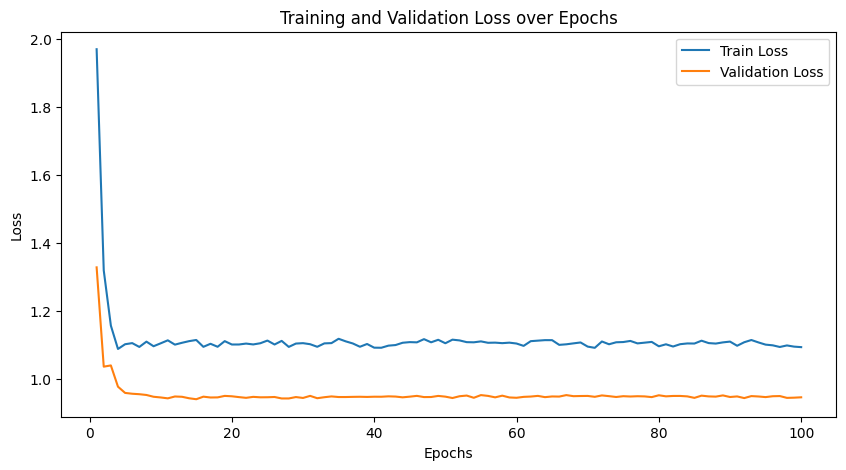

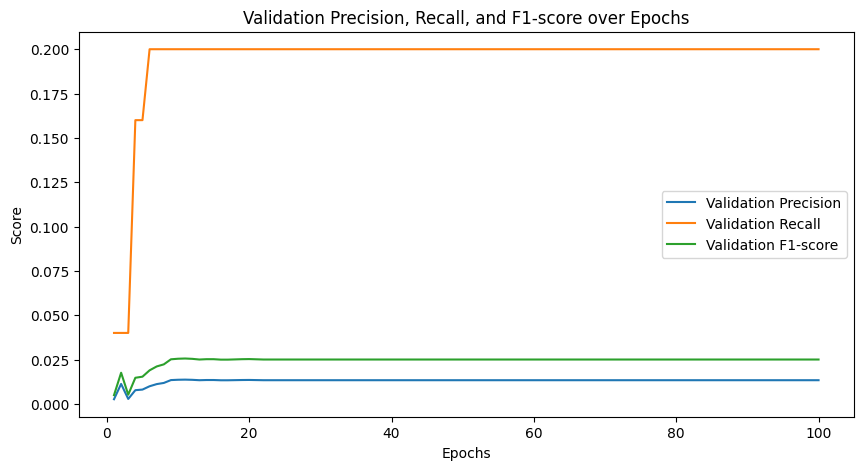

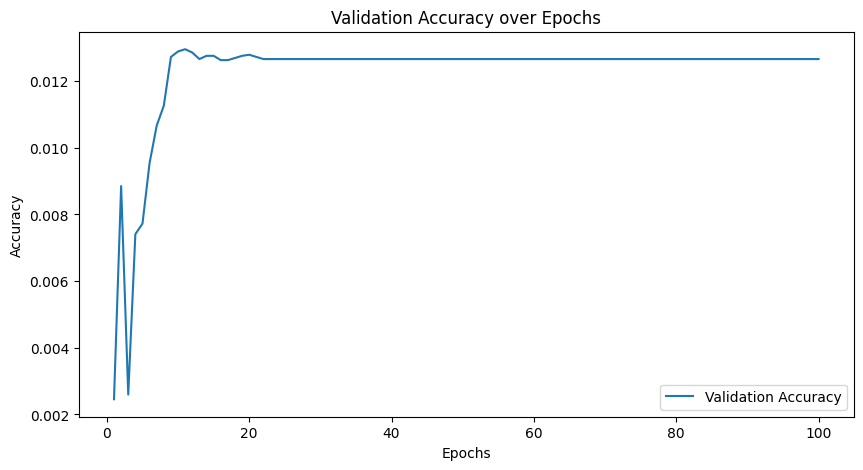

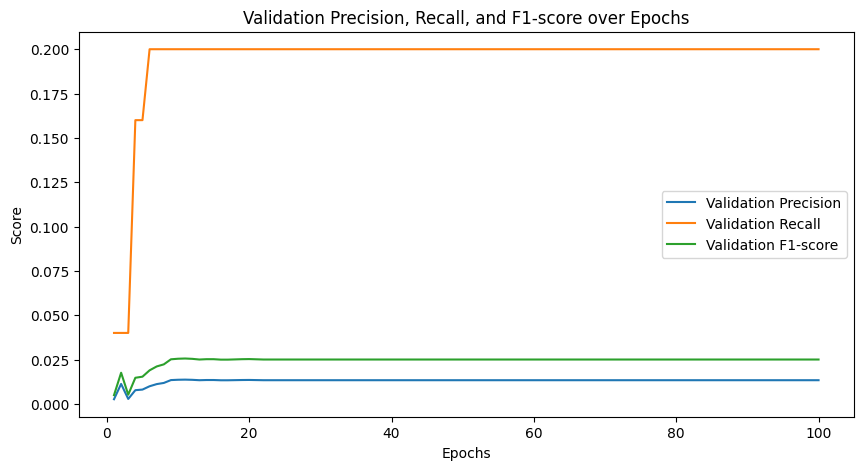

Epoch [100/100] Metrics:
Total True Positives: 5
Total False Positives: 370
Total False Negatives: 20


In [4]:
import os
import torch
import numpy as np
from PIL import Image, ImageDraw
import json
import torchvision
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torchvision.ops import box_iou

# Ensure that the code runs on the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Custom Transforms
class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        image = image.type(torch.float32)
        return image, target

class RandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            # Flip image horizontally
            image = F.hflip(image)
            
            # Flip bounding boxes
            if 'boxes' in target:
                bbox = target['boxes']
                width = image.shape[-1]
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target['boxes'] = bbox

            # Flip masks
            if 'masks' in target:
                target['masks'] = target['masks'].flip(-1)
        return image, target

# Custom Compose
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# Data Transformations
def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.image_names = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Load image
        img_name = self.image_names[idx]
        img_path = os.path.join(self.images_dir, img_name)
        img = Image.open(img_path)

        # Convert image to RGB if necessary
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Load annotation
        annot_name = os.path.splitext(img_name)[0] + '.json'
        annot_path = os.path.join(self.annotations_dir, annot_name)
        if not os.path.exists(annot_path):
            raise FileNotFoundError(f"Annotation file not found: {annot_path}")

        with open(annot_path, 'r') as f:
            data = json.load(f)

        # Initialize lists for boxes, labels, masks
        boxes = []
        labels = []
        masks = []

        for shape in data['shapes']:
            if shape['shape_type'] == 'polygon':
                points = shape['points']
                # Flatten the points for mask creation
                flattened_points = [tuple(point) for point in points]

                # Create mask
                mask = Image.new('L', img.size, 0)
                ImageDraw.Draw(mask).polygon(flattened_points, outline=1, fill=1)
                mask = np.array(mask)

                # Get bounding box coordinates
                xs = [p[0] for p in points]
                ys = [p[1] for p in points]
                xmin = min(xs)
                xmax = max(xs)
                ymin = min(ys)
                ymax = max(ys)
                boxes.append([xmin, ymin, xmax, ymax])

                # Append label (assuming single class)
                labels.append(1)  # Class index 1 (0 is reserved for background)

                # Append mask
                masks.append(mask)

        # Convert everything into torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if len(masks) > 0:
            masks = np.stack(masks, axis=0)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
        else:
            masks = torch.zeros((0, img.size[1], img.size[0]), dtype=torch.uint8)

        image_id = torch.tensor([idx])

        # Compute areas and iscrowd
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target['area'] = areas
        target['iscrowd'] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

# Model Definition
def get_instance_segmentation_model(num_classes):
    # Load a pre-trained model for classification and return only the features
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    model = MaskRCNN(backbone, num_classes=num_classes)
    return model

# Paths to your dataset
train_images_dir = 'dataset/train/images'          # Replace with your path
train_annotations_dir = 'dataset/train/annotations'  # Corrected path
val_images_dir = 'dataset/val/images'              # Replace with your path
val_annotations_dir = 'dataset/val/annotations'      # Corrected path

# Create datasets
dataset = CustomDataset(train_images_dir, train_annotations_dir, transforms=get_transform(train=True))
dataset_test = CustomDataset(val_images_dir, val_annotations_dir, transforms=get_transform(train=False))

# Data Loaders
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=collate_fn
)

# Model Initialization
num_classes = 2  # 1 class (Breakup) + background
model = get_instance_segmentation_model(num_classes)
model.to(device)

# Optimizer and Learning Rate Scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# ... [Previous code remains unchanged up to the Training Loop] ...

# Initialize lists to store losses and metrics
train_losses = []
val_losses = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_accuracies = []  # List to store accuracy values

# Training Loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for i, (images, targets) in enumerate(data_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(data_loader)}], Loss: {losses.item():.4f}")

    # Compute average training loss
    avg_train_loss = total_train_loss / len(data_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    total_val_loss = 0
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    with torch.no_grad():
        for images, targets in data_loader_test:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Temporarily set model to training mode to compute loss
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_val_loss += losses.item()

            # Switch back to evaluation mode for predictions
            model.eval()
            outputs = model(images)

            # Compute metrics
            for i in range(len(images)):
                pred_boxes = outputs[i]['boxes'].detach().cpu()
                pred_scores = outputs[i]['scores'].detach().cpu()
                pred_labels = outputs[i]['labels'].detach().cpu()

                gt_boxes = targets[i]['boxes'].detach().cpu()
                gt_labels = targets[i]['labels'].detach().cpu()

                # Set thresholds
                iou_threshold = 0.5
                score_threshold = 0.05

                # Filter out low-confidence predictions
                keep = pred_scores >= score_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                # Compute IoU between predicted and ground truth boxes
                if len(pred_boxes) == 0 and len(gt_boxes) == 0:
                    continue  # No objects detected or present
                elif len(pred_boxes) == 0:
                    total_false_negatives += len(gt_boxes)
                    continue
                elif len(gt_boxes) == 0:
                    total_false_positives += len(pred_boxes)
                    continue

                ious = box_iou(pred_boxes, gt_boxes)
                max_ious, gt_indices = ious.max(dim=1)

                # Initialize matched ground truth boxes
                matched_gt = set()

                for idx, (iou, gt_idx) in enumerate(zip(max_ious, gt_indices)):
                    if iou >= iou_threshold and gt_idx.item() not in matched_gt:
                        total_true_positives += 1
                        matched_gt.add(gt_idx.item())
                    else:
                        total_false_positives += 1

                total_false_negatives += len(gt_boxes) - len(matched_gt)

    # Compute average validation loss
    avg_val_loss = total_val_loss / len(data_loader_test)
    val_losses.append(avg_val_loss)

    # Compute precision, recall, F1-score, and accuracy
    precision = total_true_positives / (total_true_positives + total_false_positives + 1e-6)
    recall = total_true_positives / (total_true_positives + total_false_negatives + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = total_true_positives / (total_true_positives + total_false_positives + total_false_negatives + 1e-6)

    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1_score)
    val_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, "
          f"F1-score: {f1_score:.4f}, "
          f"Accuracy: {accuracy:.4f}")

    # Update the learning rate
    lr_scheduler.step()

    # Save the model after each epoch
    torch.save(model.state_dict(), f'mask_rcnn_epoch_{epoch+1}.pth')
    print(f"Model saved at epoch {epoch+1}")

print("Training completed.")

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot precision, recall, and F1-score over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), val_precisions, label='Validation Precision')
plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall')
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Precision, Recall, and F1-score over Epochs')
plt.legend()
plt.show()

# Plot accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

# ... [Rest of the code remains unchanged] ...


# Plot precision, recall, and F1-score over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), val_precisions, label='Validation Precision')
plt.plot(range(1, num_epochs+1), val_recalls, label='Validation Recall')
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Precision, Recall, and F1-score over Epochs')
plt.legend()
plt.show()

# Visualization Function (Optional)
def visualize_prediction(image_path, model, threshold=0.5):
    model.eval()
    img = Image.open(image_path)

    # Convert image to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')

    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    output = outputs[0]
    pred_scores = output['scores'].detach().cpu().numpy()
    pred_labels = output['labels'].detach().cpu().numpy()
    pred_masks = output['masks'].detach().cpu().numpy()
    pred_boxes = output['boxes'].detach().cpu().numpy()

    # Filter predictions based on threshold
    keep = pred_scores >= threshold

    pred_scores = pred_scores[keep]
    pred_labels = pred_labels[keep]
    pred_masks = pred_masks[keep]
    pred_boxes = pred_boxes[keep]

    # Plotting
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    for i in range(len(pred_masks)):
        mask = pred_masks[i][0]
        rgba_mask = np.zeros((*mask.shape, 4))
        rgba_mask[..., 0] = 1.0  # Red channel
        rgba_mask[..., -1] = mask * 0.5  # Alpha channel
        ax.imshow(rgba_mask)

        # Draw bounding box
        xmin, ymin, xmax, ymax = pred_boxes[i]
        rect = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color='red', linewidth=2
        )
        ax.add_patch(rect)

        # Add label
        ax.text(
            xmin, ymin - 10, f"Class: {pred_labels[i]}, Score: {pred_scores[i]:.2f}",
            color='red', fontsize=12, backgroundcolor='white'
        )

    plt.axis('off')
    plt.show()
# After computing total_true_positives, total_false_positives, total_false_negatives
print(f"Epoch [{epoch+1}/{num_epochs}] Metrics:")
print(f"Total True Positives: {total_true_positives}")
print(f"Total False Positives: {total_false_positives}")
print(f"Total False Negatives: {total_false_negatives}")

# Example usage
# After training, you can visualize predictions on a test image
# test_image_path = '/path/to/your/test/image.jpg'  # Replace with your test image path
# visualize_prediction(test_image_path, model, threshold=0.5)


In [1]:
!pip freeze > requirements.txt

In [2]:
import sys
print(sys.version)


3.8.20 (default, Oct  3 2024, 15:24:27) 
[GCC 11.2.0]
